# Calculates and plots the *NIWA SOI*

The NIWA SOI is calculated using the Troup method, where the climatological period is taken to be 1941-2010:

Thus, if T and D are the monthly pressures at Tahiti and Darwin, respectively, and Tc and Dc the climatological monthly pressures, then:

```
SOI    =   [ (T – Tc) – (D – Dc) ]  /  [ StDev (T – D)  ]
```
So the numerator is the anomalous Tahiti-Darwin difference for the month in question, and the denominator is the standard deviation of
the Tahiti-Darwin differences for that month over the 1941-2010 climatological period. I then round the answer to the nearest tenth
(ie, 1 decimal place).

In [1]:
%matplotlib inline

### imports

In [2]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import ma
import urllib2
import requests
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from dateutil import parser as dparser
from datetime import datetime, timedelta
import subprocess

### defines a function to get the BoM SLP data for Tahiti or Darwin

In [4]:
def get_BOM_MSLP(station='tahiti', proxies={}):
    url = "ftp://ftp.bom.gov.au/anon/home/ncc/www/sco/soi/{}mslp.html".format(station)
    r = urllib2.urlopen(url)
    if r.code == 200:
        print("streaming MSLP data for {} successful\n".format(station))
    else:
        print("!!! unable to stream MSLP data for {}\n".format(station))
        sys.exit(1)
    data = r.readlines()
    r.close()
    fout = open('./{}_text'.format(station), 'w')
    if station == 'tahiti':
        data = data[15:-3]
    else:
        data = data[14:-3]
    fout.writelines(data)
    fout.close()
    data = pd.read_table('./{}_text'.format(station),sep='\s*', \
                         engine='python', na_values='*', index_col=['Year'])
    subprocess.Popen(["rm {}*".format(station)], shell=True, stdout=True).communicate()
    return(data)

### set up the paths

In [5]:
# figure
fpath = os.path.join(os.environ['HOME'], 'operational/ICU/indices/figures')
# csv file
opath = os.path.join(os.environ['HOME'], 'operational/ICU/indices/data')

### set up the plotting parameters

In [23]:
years   = YearLocator()
months  = MonthLocator()
mFMT = DateFormatter('%b')
yFMT = DateFormatter('\n\n%Y')
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2

### set up proxies

In [8]:
proxies = {}
proxies['http'] = 'http://www-proxy.niwa.co.nz:80'
proxies['https'] = 'http://www-proxy.niwa.co.nz:80'
proxies['ftp'] = 'http://www-proxy.niwa.co.nz:80'

### use urllib2 to open remote http files
urllib2proxy = urllib2.ProxyHandler(proxies)
opener = urllib2.build_opener(urllib2proxy)
urllib2.install_opener(opener)

### preliminary: wet get the date for which the next update is likely to be made available

In [9]:
url = "http://www.bom.gov.au/climate/current/soihtm1.shtml"
r = requests.get(url, proxies=proxies)
urlcontent = r.content
date_update = urlcontent[urlcontent.find("Next SOI update expected:"):\
                         urlcontent.find("Next SOI update expected:")+60]
date_update = date_update.split("\n")[0]
print date_update
print(10*'='+'\n')

Next SOI update expected: Monday 4, May 2015



### Get the data for Tahiti

In [10]:
tahitidf = get_BOM_MSLP(station='tahiti')


streaming MSLP data for tahiti successful



### Get the data for Darwin

In [11]:
darwindf = get_BOM_MSLP(station='darwin')

streaming MSLP data for darwin successful



### defines climatological period here

In [14]:
clim_start = 1941
clim_end = 2010
clim = "{}_{}".format(clim_start, clim_end)

### calculates the climatology

In [15]:
tahiti_cli = tahitidf.loc[clim_start:clim_end,:]
darwin_cli = darwindf.loc[clim_start:clim_end,:]

tahiti_mean = tahiti_cli.mean(0)
darwin_mean = darwin_cli.mean(0)

### Calculates the SOI

In [28]:
soi = ((tahitidf - tahiti_mean) - (darwindf - darwin_mean)) / ((tahiti_cli -  darwin_cli).std(0))

soi = np.round(soi, 1)

In [29]:
soi.tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2011,2.0,2.0,2.1,2.3,0.3,0.1,1.1,0.2,1.1,0.7,1.3,2.2
2012,1.0,0.2,0.3,-0.5,-0.1,-1.0,-0.1,-0.5,0.2,0.2,0.3,-0.7
2013,-0.1,-0.3,1.1,0.1,0.9,1.5,0.9,-0.0,0.3,-0.2,0.8,-0.0
2014,1.2,-0.1,-1.2,0.9,0.6,-0.1,-0.3,-1.1,-0.8,-0.8,-1.0,-0.6
2015,-0.7,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### writes the CSV file

In [30]:
soi.to_csv(os.path.join(opath, "NICO_NIWA_SOI_{}.csv".format(clim)))

### stacks everything and set a Datetime index

In [31]:
ts_soi = pd.DataFrame(soi.stack())

dates = []
for i in xrange(len(ts_soi)):
    dates.append(dparser.parse("{}-{}-1".format(ts_soi.index.get_level_values(0)[i], ts_soi.index.get_level_values(1)[i])))

ts_soi.index = dates
ts_soi.columns = [['soi']]

In [33]:
ts_soi.tail()

,soi
2014-11-01,-1.0
2014-12-01,-0.6
2015-01-01,-0.7
2015-02-01,0.0
2015-03-01,-1.0


### choose the period of display

In [34]:
ts_soi = ts_soi.truncate(before="2012/1/1")

### 3 months rolling mean, and some data munging

In [35]:
ts_soi[['soirm']] = pd.rolling_mean(ts_soi, 3, center=True)

dates = np.array(ts_soi.index.to_pydatetime())
widths=np.array([(dates[j+1]-dates[j]).days for j in range(len(dates)-1)] + [30])

### middle of the month for the 3 month running mean plot
datesrm = np.array([x + timedelta(days=15) for x in dates])

soi = ts_soi['soi'].values
soim = ts_soi['soirm'].values

### plots the SOI, lots of boilerplate here

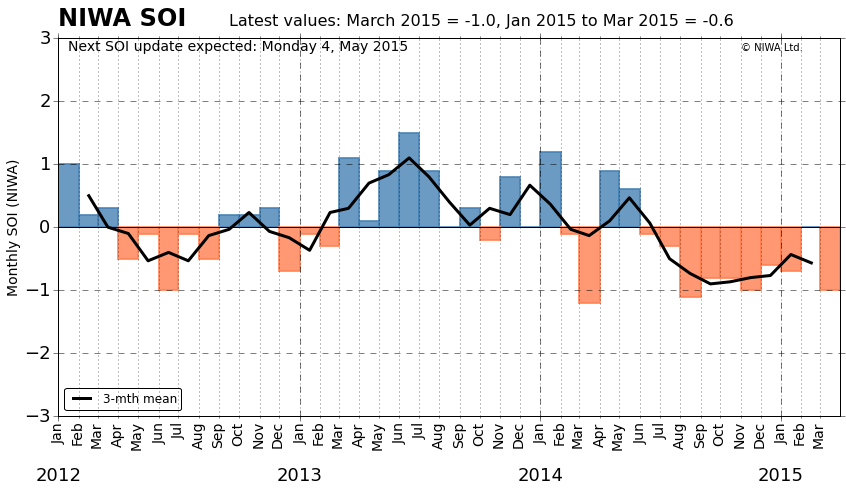

In [36]:
fig, ax = plt.subplots(figsize=(14,7))
fig.subplots_adjust(bottom=0.15)


ax.bar(dates[soi>=0],soi[soi>=0], width=widths[soi>=0], facecolor='steelblue', \
       alpha=.8, edgecolor='steelblue', lw=2)

ax.bar(dates[soi<0],soi[soi<0], width=widths[soi<0], facecolor='coral', \
       alpha=.8, edgecolor='coral', lw=2)

ax.plot(datesrm,soim, lw=3, color='k', label='3-mth mean')

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_formatter(mFMT)
ax.xaxis.set_major_formatter(yFMT)
ax.axhline(0, color='k')

#ax.set_frame_on(False)
labels = ax.get_xminorticklabels()
for label in labels:
    label.set_fontsize(14)
    label.set_rotation(90)
labels = ax.get_xmajorticklabels()
for label in labels:
    label.set_fontsize(18)
labels = ax.get_yticklabels()
for label in labels:
    label.set_fontsize(18)

ax.grid(linestyle='--')
ax.xaxis.grid(True, which='both')
ax.legend(loc=3, fancybox=True)
ax.set_ylim(-3., 3.)
ax.set_ylabel('Monthly SOI (NIWA)', fontsize=14, backgroundcolor="w")
ax.text(dates[0],3.2,"NIWA SOI", fontsize=24, fontweight='bold')
ax.text(dates[-5], 2.8, "%s NIWA Ltd." % (u'\N{Copyright Sign}'))

textBm = "%s = %+4.1f" % (dates[-1].strftime("%B %Y"), soi[-1])
textBs = "%s to %s = %+4.1f" % (dates[-3].strftime("%b %Y"), dates[-1].strftime("%b %Y"), soi[-3:].mean())

ax.text(datesrm[8],3.2,"Latest values: %s, %s" % (textBm, textBs), fontsize=16)
ax.text(datesrm[0],2.8,date_update, fontsize=14)

### saves the figure

In [39]:
fig.savefig(os.path.join(fpath, "NICO_NIWA_SOI_{}clim.png".format(clim)), dpi=200)